<a href="https://colab.research.google.com/github/pavan-kalam/PDS-Project/blob/main/deepfake_cnn_with_data_augumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install opendatasets

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt
import opendatasets as od
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def download_dataset():
    if not os.path.exists('/content/drive/MyDrive/deepfake-and-real-images'):
        print("Downloading dataset...")
        od.download("https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images")
        print("Dataset downloaded successfully!")
    else:
        print("Dataset already exists!")

# Download the dataset
print("Checking for dataset...")
download_dataset()

Checking for dataset...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pavankalam
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images


100%|██████████| 1.68G/1.68G [00:48<00:00, 37.4MB/s]



Dataset downloaded successfully!


In [ ]:
def create_data_augmentation():
    # Create an instance of ImageDataGenerator for data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return datagen

# Create data augmentation
datagen = create_data_augmentation()

In [ ]:
def load_dataset_with_augmentation(path, datagen):
    # Load the dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='binary',
        color_mode="rgb",
        batch_size=32,
        image_size=(128, 128),
        shuffle=True,
        seed=123,
    )

    # Create a generator for the training data
    train_data = datagen.flow_from_directory(
        path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        shuffle=True
    )

    return train_data

def load_dataset(path):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='binary',
        color_mode="rgb",
        batch_size=32,
        image_size=(128, 128),
        shuffle=True,
        seed=123,
    )

# Load and preprocess the dataset with augmentation
dataset_path = 'deepfake-and-real-images/Dataset'
train_data = load_dataset_with_augmentation(os.path.join(dataset_path, 'Train'), datagen)
val_data = load_dataset(os.path.join(dataset_path, 'Validation'))

Found 140002 files belonging to 2 classes.
Found 140002 images belonging to 2 classes.
Found 39428 files belonging to 2 classes.


In [ ]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding='same', input_shape=(128, 128, 3)),
        layers.Conv2D(32, (3,3), activation="relu", padding='same'),

        layers.MaxPooling2D((2,2), strides=(2, 2)),


        layers.Conv2D(64, (3,3), activation="relu", padding='same'),
        layers.Conv2D(64, (3,3), activation="relu", padding='same'),

        layers.MaxPooling2D((2,2), strides=(2, 2)),

        layers.Conv2D(128, (3,3), activation="relu", padding='same'),
        layers.Conv2D(128, (3,3), activation="relu", padding='same'),

        layers.MaxPooling2D((2,2), strides=(2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Create the model
model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def train_model(model, train_data, val_data, epochs=10):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[early_stopping_cb]
    )


    return history

# Train the model
history = train_model(model, train_data, val_data, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 980s 221ms/step - accuracy: 0.6367 - loss: 0.6563 - val_accuracy: 0.8551 - val_loss: 0.3437
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 904s 205ms/step - accuracy: 0.8567 - loss: 0.3349 - val_accuracy: 0.8863 - val_loss: 0.2780
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 901s 206ms/step - accuracy: 0.9039 - loss: 0.2387 - val_accuracy: 0.9110 - val_loss: 0.2184
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 924s 206ms/step - accuracy: 0.9220 - loss: 0.1974 - val_accuracy: 0.9264 - val_loss: 0.1960
Epoch 5/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 905s 202ms/step - accuracy: 0.9327 - loss: 0.1708 - val_accuracy: 0.9258 - val_loss: 0.1849
Epoch 6/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 884s 202ms/step - accuracy: 0.9405 - loss: 0.1512 - val_accuracy: 0.9384 - val_loss: 0.1540
Epoch 7/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 918s 201ms/step - accuracy: 0.9466 - loss: 0.1391 - val_accuracy: 0.9330 - val_loss: 0.1786
Epoch 8/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 879s 201ms/step - accuracy: 0.9

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,544,165 (51.67 MB)

 Trainable params: 4,514,721 (17.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,029,444 (34.44 MB)

In [ ]:
# Create directory for models if it doesn't exist
os.makedirs('/content/drive/MyDrive/PDS_deepfake_project', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation/model', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation/visualization', exist_ok=True)

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation/model/deepfake-model.keras')
print("Model trained and saved.")

Model trained and saved.


In [ ]:
def evaluate_model(model, val_data):
    loss, accuracy = model.evaluate(val_data)
    print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model(model, val_data)

1233/1233 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.9520 - loss: 0.1288
Validation Loss: 0.1290, Validation Accuracy: 0.9514


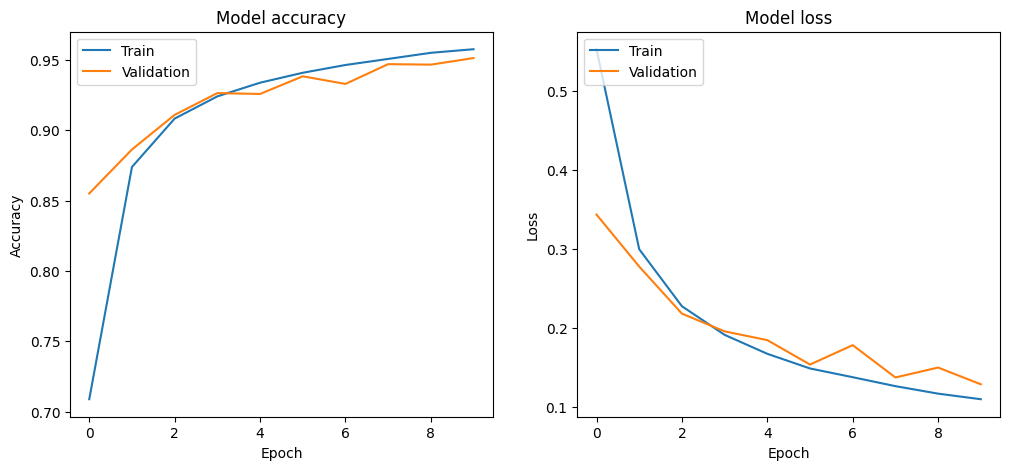

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation/visualization/model_accuracy.png')  # Save accuracy plot

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation/visualization/model_loss.png')  # Save loss plot

    plt.show()

# Call the function after training the model
plot_training_history(history)

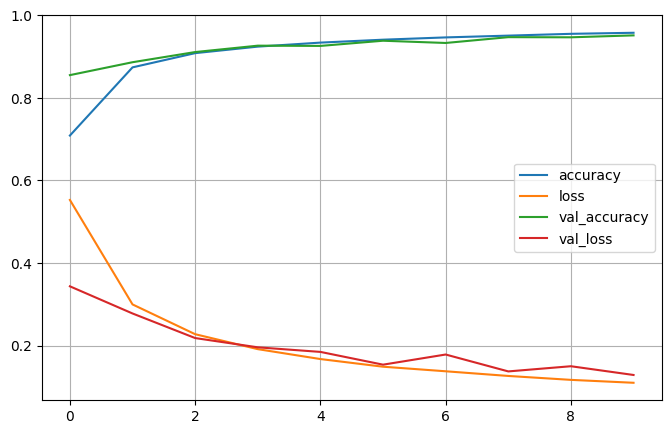

In [ ]:
import pandas as pd

# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.savefig('/content/drive/MyDrive/PDS_deepfake_project/deepfake-model-with-data-augumentation/visualization/training_history.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

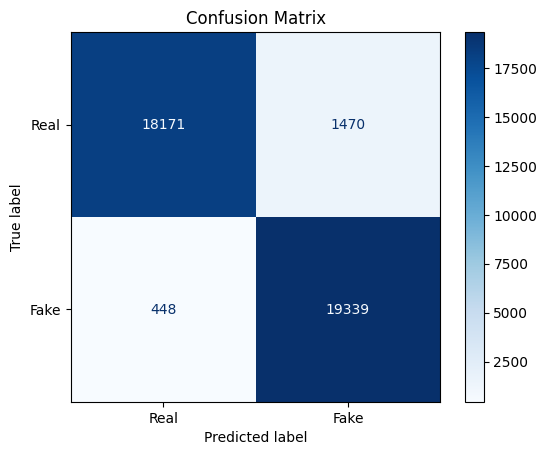

In [ ]:
def plot_confusion_matrix(model, val_data):
    y_true = []
    y_pred = []

    for images, labels in val_data:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig('/content/drive/MyDrive/PDS_deepfake_project/deepfake-with-data-augumentation/visualization/confusion_matrix.png')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(model, val_data)